In [ ]:

%matplotlib inline
from torch.nn import functional as F
from torch import nn
import torch.utils.data as data
import torchvision.transforms as transforms
import os
import torch
import PIL.Image as Image
import csv
from sklearn.preprocessing import LabelEncoder
import time
import matplotlib.pyplot as plt
import numpy as np

# 设置工作目录
os.chdir("/home/zs/project/classify-leaves/")

encoder = LabelEncoder()

class MyDataset(data.Dataset):

    def __init__(self, csv_path, is_test=False):
        self.is_test = is_test
        self.filenames = []
        self.labels = []
        current_directory = os.getcwd()
        with open(csv_path, 'r') as f:
            reader = csv.reader(f)
            for row in reader:
                if row[0] == 'image':
                    continue
                elif is_test:
                    self.filenames.append(os.path.join(current_directory, row[0]))
                else:
                    self.labels.append(row[1])
                    self.filenames.append(os.path.join(current_directory, row[0]))
            # 打印列表中元素不同的个数
            print(len(set(self.filenames)))

            # 使用LabelEncoder将字符串转换为数字
            global encoder
            if not is_test:
                labels_encoded = encoder.fit(self.labels)
                LabelEncoder()
                labels_encoded = encoder.transform(self.labels)
                # 然后将numpy数组转换为张量
                self.labels = torch.tensor(labels_encoded)

    def __getitem__(self, index ):
        image = Image.open(self.filenames[index])
        data = self.preprocess(image)
        if self.is_test:
            return data
        else:
            label = self.labels[index]
            return data ,label

    def __len__(self):
        return len(self.filenames)

    def preprocess(self, data):
        transform_train_list = [
            # transforms.Resize((self.opt.h, self.opt.w), interpolation=3),
            # transforms.Pad(self.opt.pad, padding_mode='edge'),
            # transforms.RandomCrop((self.opt.h, self.opt.w)),
            # transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]
        return transforms.Compose(transform_train_list)(data)



In [ ]:

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            input_channels, num_channels, kernel_size=3, padding=1, stride=strides
        )
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(
                input_channels, num_channels, kernel_size=1, stride=strides
            )
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)


b1 = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
)


def resnet_block(input_channels, num_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(
                Residual(input_channels, num_channels,
                         use_1x1conv=True, strides=2)
            )
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk


b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))


net = nn.Sequential(
    b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d(
        (1, 1)), nn.Flatten(), nn.Linear(512, 176)
)


def togpu(x):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return x.to(device)


In [ ]:
batch_size = 64  # 设置批量大小为128
lr, num_epochs = 0.005,50

In [ ]:
train_dataset = MyDataset("train.csv")
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


In [ ]:
test_dataset = MyDataset('test.csv', is_test=True)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [ ]:
def train(net):  # 定义训练函数，输入参数为网络模型
    

    train_loss = []  # 训练损失数组
    acc = []  # 准确率数组
    x = list(range(0, num_epochs))  # epoch array
    # 作图，开启交互模式
    plt.ion()
    
    if torch.cuda.device_count() > 1:
        print("useing", torch.cuda.device_count(), "GPUs!")
        net = nn.DataParallel(net)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net = net.to(device)

    print("training on", device)  # 打印正在使用的设备
    

    optimizer = torch.optim.SGD(
        net.parameters(), lr=lr
    )  # 使用SGD优化器，输入参数为网络模型的参数和学习率
    loss = nn.CrossEntropyLoss()  # 使用交叉熵损失函数
    for epoch in range(num_epochs):  # 对每一轮训练进行循环
        train_l_sum, train_acc_sum, n, start = (
            0.0,
            0.0,
            0,
            time.time(),
        )  # 初始化损失和准确率的累计值，以及计时器
        for X, y in train_loader:  # 对训练数据进行循环
            X, y = togpu(X), togpu(y)  # 将数据移动到GPU（如果可用）
            y_hat = net(X)  # 使用网络模型对输入数据进行预测
            l = loss(y_hat, y)  # 计算预测结果和真实标签之间的损失
            optimizer.zero_grad()  # 清零优化器的梯度
            l.backward()  # 对损失进行反向传播，计算梯度
            optimizer.step()  # 使用优化器更新网络模型的参数
            train_l_sum += l.cpu().item()  # 累加损失
            train_acc_sum += (y_hat.argmax(dim=1) ==
                              y).sum().cpu().item()  # 累加准确率
            n += y.shape[0]  # 累加样本数量
        
        # 作图
        train_loss.append(train_l_sum / n)  # 计算每轮训练的平均损失
        acc.append(train_acc_sum / n)  # 计算每轮训练的平均准确率

        ix = x[:epoch +1  ]
        train_iy = train_loss
        valid_iy = acc
        plt.cla()
        plt.title("loss")
        plt.plot(ix, train_iy, label='Train Loss', linewidth=2, linestyle='-', marker='o')
        plt.plot(ix, valid_iy, label='Acc ', color="orange", linewidth=2, linestyle='--', marker='s')
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend()
        plt.pause(0.5)
        
            
        print(
            "epoch %d, loss %.4f, train acc %.3f, time %.1f sec"
            % (epoch + 1, train_l_sum / n, train_acc_sum / n, time.time() - start)
        )  # 打印每轮训练的损失、准确率和时间
    plt.ioff()
    plt.show()
                 

def save_model(net, path):
    torch.save(net.state_dict(), path)
    print("saved:", path)

def load_model(net, path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.load_state_dict(torch.load(path, map_location=device))
    return net

# 加载预训练模型

pretrained_path = "/home/zs/project/classify-leaves/resnet.pth"
if os.path.exists(pretrained_path):
    net = load_model(net, pretrained_path)
    print("Loaded pretrained model")


In [ ]:
# path = "./"
# load_net(path)
train(net)  # 调用训练函数，开始训练
save_model(net, "/kaggle/working/resnet_two_gpus.pth")

In [ ]:
# del a
torch.cuda.empty_cache()
img = train_dataset.__getitem__(7)[0]
a = img.unsqueeze(0)
# 显示图片
img = np.transpose(img, (1, 2, 0))
plt.imshow(np.array(img))
plt.show()

a = togpu(a)
net = togpu(net)
net.eval()

output = net(a)
predictions = output.argmax(dim=1)
print(predictions)
predictions = predictions.cpu().numpy()
predictions = encoder.inverse_transform(predictions)
print(predictions)

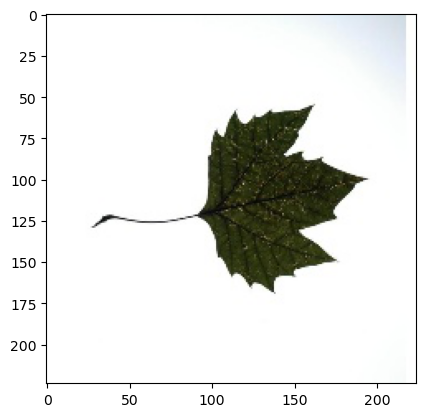

tensor([120], device='cuda:0')
['platanus_acerifolia']


In [12]:
img = test_dataset.__getitem__(2)
a = img.unsqueeze(0)
# 显示图片
img = np.transpose(img, (1, 2, 0))
plt.imshow(np.array(img))
plt.show()

a = togpu(a)
net = togpu(net)
net.eval()
output = net(a)
predictions = output.argmax(dim=1)
print(predictions)
predictions = predictions.cpu().numpy()
predictions = encoder.inverse_transform(predictions)
print(predictions)

In [13]:
import pandas as pd
test_labels = []
i = 0

for i in range(len(test_dataset)):
    test_data = test_dataset.__getitem__(i )
    test_data = test_data.unsqueeze(0)
    test_data = togpu(test_data)
    net = togpu(net)
    net.eval()
    output = net(test_data)
    predictions = output.argmax(dim=1)
    test_labels.append(predictions.cpu().numpy())

# Convert the list of numpy arrays to a single numpy array
test_labels = np.concatenate(test_labels)

# Now you can call encoder.inverse_transform
test_labels = encoder.inverse_transform(test_labels)

test_df = pd.read_csv('test.csv')

test_df['label'] = test_labels

test_df.to_csv('/kaggle/working/submission.csv', index=False)
print("################################")

KeyboardInterrupt: 